# Tutorial on  Fine-Tuning OpenAI GPT for Classification Tasks

# Running the notebook

This notebook is shared in `view only mode`. If you want to run the cells inside it, you should either:

- click on ` open in playground mode` in the `file` menu (your change won't be saved though)
- save a copy in your drive that you can open in `edit` mode to be able to save your changes.

## Introduction

## OpenAI GPT

[OpenAI GPT model](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf), is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. GPT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### This Tutorial

This post will explain how you can modify and fine-tune GPT to create a powerful NLP model that quickly gives you state of the art results. 

### Fine-Tuning OpenAI GPT

In this tutorial, we will use GPT to train a text classifier. Specifically, we will take the pre-trained GPT model, and add a classification layer on top of it. Fine-tuning is helpful for the following reasons: 

- Easy Training: The pre-trained GPT model, already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. 

- Less Data: Fine-tuning tallows us to use a much smaller dataset in comparison with a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a  large dataset in order to train our network to reasonable accuracy. By fine-tuning GPT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

- Good Performance: Fine-tuning procedure has shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of NLP  tasks.

- A Shift in NLP: This shift to transfer learning resembels the same shift that pretrained ImageNet models had on computer vision.

Also, note that, in another [tutorial](http://tiny.cc/Bert_Classification), I have  explained how to fine tune [BERT](https://arxiv.org/abs/1810.04805) for classification tasks. 

Okay, let's get started!

## Install and Import

With Google Colab you can have access to free GPUs and TPUs! In casae we have a  large neural network it's best to take advantage of this (in this case we'll attach a GPU). For this tutorial you can also use CPU, but it takes a long time!!

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
in case of runing out of memory
# !pkill -9 -f ipykernel_launcher


In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for GPT by [Hugging Face](https://github.com/huggingface/pytorch-transformers)

In [0]:
!pip install pytorch-transformers

In [0]:
!pip install pytorch-ignite ipdb

In [4]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


**Importing some classes from pytorch_transformers**

In [0]:
from pytorch_transformers import cached_path
from pytorch_transformers import AdamW, WarmupLinearSchedule

# GPT2 Related
from  pytorch_transformers import OpenAIGPTTokenizer
from  pytorch_transformers import OpenAIGPTModel

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Tokenizer

To simplify pre-processing, we'll use a pre-defined open vocabulary tokenizer: the tokenizer of the GPT model.

In [7]:
gpttokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

W0820 22:36:33.924742 140210205075328 tokenization_openai.py:96] ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [8]:
gpttokenizer.vocab_size

40478

Need to add classification token to the tokenizer

In [0]:
gpttokenizer.add_special_tokens({'cls_token': '[CLS]'})

In [10]:
gpttokenizer.convert_tokens_to_ids(gpttokenizer.cls_token)

40478

## Load and prepare CoLA dataset

[CoLA](https://nyu-mll.github.io/CoLA/) dataset is a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive. Both tokenized and raw versions of the data are available. We will use the  GPT tokenizer to tokenize it.

In [0]:
# Upload the train file from your local drive; if you get out of memory error, upload by the tab file 'upload'
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [16]:
df.shape

(8551, 4)

In [17]:
df.sample(5)

,sentence_source,label,label_notes,sentence
2460,l-93,1,NaN,On the windowsill is a flowering plant.
3810,ks08,1,NaN,To delay the march and to go ahead with it hav...
5330,b_82,0,*,"Those people will, after the party, not come h..."
4937,ks08,1,NaN,"John has two sisters, who became lawyers."
3450,ks08,0,*,The evidence that John found was more helpful ...


### Create sentence and label lists

In [0]:
sentences = df.sentence.values
labels = df.label.values

In [0]:
s0 = sentences[0]

In [20]:
print(s0)

Our friends won't buy this analysis, let alone the next one we propose.


In [21]:
[gpttokenizer.tokenize(s0)]

[['our</w>',
  'friends</w>',
  'won</w>',
  "'</w>",
  't</w>',
  'buy</w>',
  'this</w>',
  'analysis</w>',
  ',</w>',
  'let</w>',
  'alone</w>',
  'the</w>',
  'next</w>',
  'one</w>',
  'we</w>',
  'propose</w>',
  '.</w>']]

In [22]:
tokenized_texts = [gpttokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['our</w>', 'friends</w>', 'won</w>', "'</w>", 't</w>', 'buy</w>', 'this</w>', 'analysis</w>', ',</w>', 'let</w>', 'alone</w>', 'the</w>', 'next</w>', 'one</w>', 'we</w>', 'propose</w>', '.</w>']


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [0]:
# Use the GPT tokenizer to convert the tokens to their index numbers in the GPT vocabulary
input_ids = [gpttokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [25]:
print(input_ids[:2])

[[622, 1662, 5011, 256, 241, 3487, 616, 13542, 240, 851, 1552, 481, 1115, 566, 606, 14568, 239], [566, 725, 27889, 2192, 24396, 488, 249, 256, 258, 2081, 609, 239]]


In [0]:
# Padding
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN-1, dtype="long", truncating="post", padding="post")

In [0]:
#appending CLS token to the end of input id
input_ids = [np.append(x, gpttokenizer.convert_tokens_to_ids('[CLS]'))  for x in input_ids]

In [28]:
print(input_ids[0])

[  622  1662  5011   256   241  3487   616 13542   240   851  1552   481
  1115   566   606 14568   239     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 40478]


Use train_test_split to split our data into train and validation sets for training

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.05)


In [0]:
# Convert all of our data into torch tensors, the required type for our pytorch model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)


In [31]:
print(train_inputs.shape)

torch.Size([8123, 128])


In [32]:
print(train_inputs[0])

tensor([ 2476,  2528,  4528,  2846,   239,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 40478])

Select a batch size for training. 

For fine-tuning GPT on a specific task, the authors recommend a batch size of 16 or 32. Create an iterator of our data with torch DataLoader. 

In [0]:
batch_size = 16

# Training
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation
validation_data = TensorDataset(validation_inputs, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Creating Classification Model

Now what we need to do is to add a single classification layer on top of GPT model. As we feed input data, the entire pre-trained GPT's model and the additional untrained classification layer is trained on our specific task. Alternatively, we can freez all layers and just fine tune the classification head.

Also note that, as we've showed beforehand, the last token of every sequence is the special classification token ("[CLS]"). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size "[hidden_state, number_of_labels]"", so "[768,2]". 

### Adding a classification head

In [0]:
class GPTWithClfHead(nn.Module):
    def __init__(self, config, adapt_args, gptmodel):
        super().__init__()
        self.transformer = gptmodel
        self.num_labels = adapt_args.num_classes
        self.classifier = nn.Linear(config['n_embd'], adapt_args.num_classes)

    
    def forward(self, input_ids, mc_token_ids=None, labels=None, token_type_ids=None,
                position_ids=None, past=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, position_ids=position_ids, token_type_ids=token_type_ids
                                               , head_mask=head_mask)
        hidden_states = transformer_outputs[0]
        

        # last token of the sequence is classification token
        token_ids = torch.full_like(hidden_states[..., :1, :], hidden_states.shape[-2]-1, dtype=torch.long)
        output = hidden_states.gather(-2, token_ids).squeeze(-2) # shape (bsz, n_embd)

        clf_logits = self.classifier(output)
        outputs = (clf_logits,) + transformer_outputs[1:]
        if labels is not None:
          loss_fct = CrossEntropyLoss()
          loss = loss_fct(clf_logits.view(-1, self.num_labels), labels.view(-1))
          outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)


## Fine-tuning configuration

We need an additional configuration for the fine-tuning which will define the number of classes of our classification head (2 classes for the CoLA dataset) and a few optimization settings for adapatation (learning rate, batch size...)

In [0]:
from collections import namedtuple
AdaptationConfig = namedtuple('AdaptationConfig',
  field_names="num_classes, dropout, initializer_range, batch_size, lr, max_norm, n_epochs,"
              "n_warmup, valid_set_prop, gradient_accumulation_steps, device,"
              "log_dir")
adapt_args = AdaptationConfig(
               2          , 0.1    , 0.02             , 16        , 6.5e-5, 1.0   , 4,
               10      , 0.1           , 1, device,
               "./" )

loading the pretrained config for GPT model

In [0]:
gptconfig = cached_path("https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-config.json")

In [52]:
import json
with open(gptconfig, "r") as read_file:
    gptconfig = json.load(read_file)
print (gptconfig)

{'afn': 'gelu', 'attn_pdrop': 0.1, 'embd_pdrop': 0.1, 'initializer_range': 0.02, 'layer_norm_epsilon': 1e-05, 'n_ctx': 512, 'n_embd': 768, 'n_head': 12, 'n_layer': 12, 'n_positions': 512, 'n_special': 0, 'resid_pdrop': 0.1, 'vocab_size': 40478}


Loading the pretrained GPT model

In [0]:
gptmodel = OpenAIGPTModel.from_pretrained('openai-gpt')

Because we have added a new classification token, we need to resize the model

In [54]:
gptmodel.resize_token_embeddings(len(gpttokenizer))

Embedding(40479, 768)

In [0]:
model = GPTWithClfHead(gptconfig, adapt_args, gptmodel)
model.cuda()

## Training 

Below is our training loop. For each pass in our loop we have a trianing phase and a validation phase. At each pass we need to have:

**Training loop**:
-  Setting the model in train mode
- Unpack our data
- Load data onto the GPU (Optional)
- Zeroing out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default 
- Forward pass 
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution loop**:
- Setting the model in evaluation mode
- Unpack our data 
- Load data onto the GPU (Optional)
- Forward pass 
- Compute loss on our validation data and track variables for monitoring progress



In [0]:

import os
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import CosineAnnealingScheduler, PiecewiseLinear, create_lr_scheduler_with_warmup, ProgressBar
optimizer = torch.optim.Adam(model.parameters(), lr=adapt_args.lr)

train_loss_set = []

# Training function and trainer
def update(engine, batch):
    model.train()
    b_input_ids, labels = (t.to(adapt_args.device) for t in batch)
    outputs = model(input_ids = b_input_ids, labels=labels)
    loss = outputs[0]
    
    loss = loss / adapt_args.gradient_accumulation_steps
    train_loss_set.append(loss.item())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), adapt_args.max_norm)
    if engine.state.iteration % adapt_args.gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()
trainer = Engine(update)

# Evaluation function and evaluator (evaluator output is the input of the metrics)
def inference(engine, batch):
    model.eval()
    with torch.no_grad():
      b_input_ids, labels = (t.to(adapt_args.device) for t in batch)
      outputs = model(input_ids = b_input_ids)
      logits = outputs[0]
    return logits, labels
evaluator = Engine(inference)

# Attache metric to evaluator & evaluation to trainer: evaluate on valid set after each epoch
Accuracy().attach(evaluator, "accuracy")
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(validation_dataloader)
    print(f"Validation Epoch: {engine.state.epoch} accuracy: {100*(evaluator.state.metrics['accuracy'])}")
     

# Learning rate schedule: linearly warm-up to lr and then to zero
scheduler = PiecewiseLinear(optimizer, 'lr', [(0, 0.0), (adapt_args.n_warmup, adapt_args.lr),
                                              (len(train_dataloader)*adapt_args.n_epochs, 0.0)])
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# Add progressbar with loss
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
ProgressBar(persist=True).attach(trainer, metric_names=['loss'])

# @trainer.on(Events.ITERATION_COMPLETED)
@trainer.on(Events.EPOCH_COMPLETED)
def log_running_avg_metrics(engine):    
    print(f" Epoch: {engine.state.epoch} training loss: {engine.state.metrics['loss']}")
    

# Save checkpoints and finetuning config
checkpoint_handler = ModelCheckpoint(adapt_args.log_dir, 'finetuning_checkpoint', save_interval=1, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'mymodel': model})
# torch.save(args, os.path.join(adapt_args.log_dir, 'fine_tuning_args.bin'))

In [58]:
trainer.run(train_dataloader, max_epochs=adapt_args.n_epochs)

Validation Epoch: 1 accuracy: 76.16822429906543
 Epoch: 1 training loss: 0.4515294992076222


Validation Epoch: 2 accuracy: 76.4018691588785
 Epoch: 2 training loss: 0.27423131179587323


Validation Epoch: 3 accuracy: 76.4018691588785
 Epoch: 3 training loss: 0.13529682732307408


Validation Epoch: 4 accuracy: 76.4018691588785
 Epoch: 4 training loss: 0.09748851845094439


## Training Evaluation

Let's take a look at our training loss over all batches:

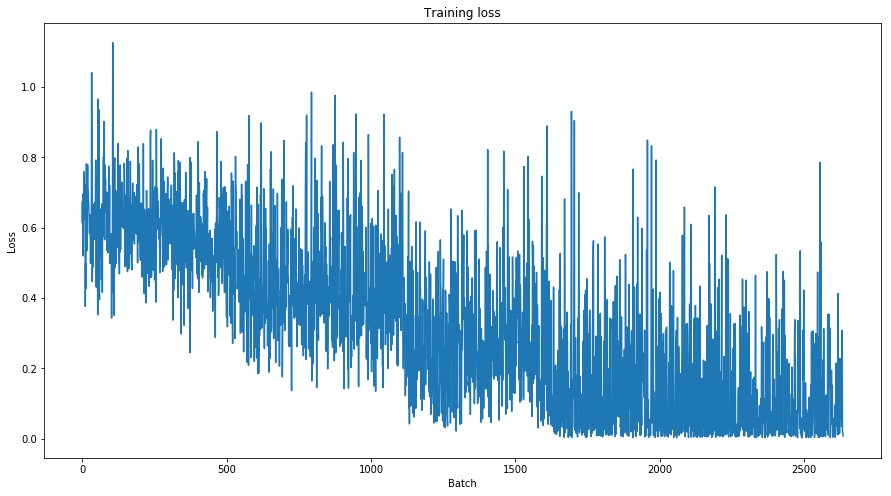

In [59]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Predicting and Evaluating on Holdout Set

First we need to load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html). This is the metric used by the  NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score.

In [0]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()

**Preparing the data**

In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values


tokenized_texts = [gpttokenizer.tokenize(sent) for sent in sentences]



MAX_LEN = 128

# input tokens
input_ids = [gpttokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN-1, dtype="long", truncating="post", padding="post")
input_ids = [np.append(x, gpttokenizer.convert_tokens_to_ids('[CLS]'))  for x in input_ids]


prediction_inputs = torch.tensor(input_ids)
prediction_labels = torch.tensor(labels)
  
batch_size = 16  


prediction_data = TensorDataset(prediction_inputs, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**Evaluating**

In [0]:
predictions , true_labels = [], []
# Evaluation function and evaluator (evaluator output is the input of the metrics)

def inference(engine, batch):
    model.eval()
    with torch.no_grad():
      b_input_ids, labels = (t.to(adapt_args.device) for t in batch)
      outputs = model(input_ids = b_input_ids)
      logits = outputs[0] 
    # Store predictions and true labels
    predictions.append(logits.detach().cpu().numpy())
    true_labels.append(labels.to('cpu').numpy())
    
    return logits, labels
evaluator = Engine(inference)

In [67]:
evaluator.run(prediction_dataloader)
# print(f"Test Results - Error rate: {100*(1.00 - evaluator.state.metrics['accuracy']):.3f}")

In [68]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.



In [69]:
matthews_set

[0.0,
 0.0,
 -0.12403473458920847,
 0.0,
 0.0,
 0.7644707871564383,
 0.5606119105813882,
 -0.0778498944161523,
 0.09759000729485333,
 0.38297084310253526,
 0.363696483726654,
 0.7453559924999299,
 0.5918640302493726,
 0.6201736729460423,
 0.2182178902359924,
 0.0,
 0.0,
 0.7125253031944253,
 0.3333333333333333,
 0.4879500364742666,
 0.38297084310253526,
 0.8320502943378436,
 0.6201736729460423,
 0.30261376633440124,
 0.5091750772173156,
 0.6546536707079772,
 0.6831300510639733,
 -0.2182178902359924,
 1.0,
 0.4622501635210242,
 0.2277100170213244,
 0.15289415743128767,
 0.0,
 0.0,
 0.0,
 -0.12403473458920847,
 0.0,
 0.0,
 0.7644707871564383,
 0.5606119105813882,
 -0.0778498944161523,
 0.09759000729485333,
 0.38297084310253526,
 0.363696483726654,
 0.7453559924999299,
 0.5918640302493726,
 0.6201736729460423,
 0.2182178902359924,
 0.0,
 0.0,
 0.7125253031944253,
 0.3333333333333333,
 0.4879500364742666,
 0.38297084310253526,
 0.8320502943378436,
 0.6201736729460423,
 0.30261376633440124,

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [71]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.36656834386413933

Great! In a short amount of time without doing any hyperparameter tuning, we were able to get a relatively good score. Also note that we didn't train on the entire training dataset, but set aside a portion of it as our validation set.

If you look at the [GLUE leaderboard](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy), you'll see that our score (37) using the small version of GPT is not too bad. If you want to tune the hyperparameters, use the entire train set, or use the larger GPT model instead you're likely able to push that score up higher into the mid- 60s and above, which looks like the state of the art as of August 2019!

# Conclusion

This post showed that with a pre-trained GPT model you can quickly and effectively develope a new model by fine tuning GPT model for your specific NLP task. To learn about Fine tuning BERT, please refer to this [tutorial](http://tiny.cc/Bert_Classification). In this classification experiment looks like BERT model is doing a better job than GPT model.